2023-02-23 15:59:42.957851: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-23 15:59:42.957996: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2
Epoch 0


2023-02-23 15:59:43.334867: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-23 15:59:43.647033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1871/1875 [============================>.] - ETA: 0s - loss: 0.1573 - accuracy: 0.9527

2023-02-23 15:59:56.873469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 15s 8ms/step - loss: 0.1573 - accuracy: 0.9527 - val_loss: 0.0489 - val_accuracy: 0.9833


2023-02-23 15:59:58.885747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 287ms/step


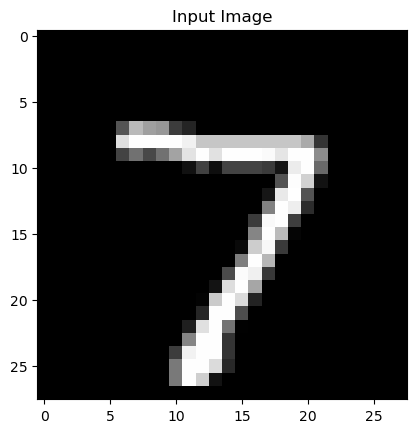

IndexError: index 4 is out of bounds for axis 0 with size 4

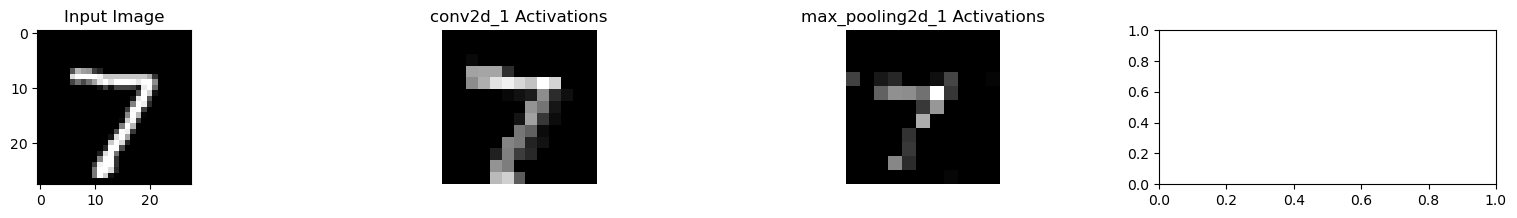

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images / 255.0
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images / 255.0

# Define the CNN architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), name='conv2d_1'),
    tf.keras.layers.MaxPooling2D((2, 2), name='max_pooling2d_1'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_2'),
    tf.keras.layers.Flatten(name='flatten'),
    tf.keras.layers.Dense(10, activation='softmax', name='output')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define a function to display the activations of each layer
def display_activations(activations, layer_names, input_image):
    # Display the input image
    plt.imshow(input_image.squeeze(), cmap='gray')
    plt.title('Input Image')
    plt.show()

    # Display the layer activations for the first test image
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 2))
    for i, layer_activation in enumerate(activations[:3]):
        # Display the input image for the first layer
        if i == 0:
            axs[i].imshow(input_image.squeeze(), cmap='gray')
            axs[i].set_title('Input Image')
        else:
            # Display the activation maps for the other layers
            axs[i].set_title(layer_names[i-1] + ' Activations')
            for j in range(layer_activation.shape[-1]):
                row, col = divmod(j, 8)
                if i == 3:
                    axs[i].imshow(layer_activation[:, j], cmap='gray')
                else:
                    axs[i].imshow(layer_activation[0, :, :, j], cmap='gray')
                axs[i].axis('off')
    axs[4].set_title(layer_names[4-1] + ' Activations')
    for j in range(layer_activation.shape[-1]):
        row, col = divmod(j, 8)
        axs[4].imshow(layer_activation[:, j], cmap='gray')
        axs[4].axis('off')
    plt.show()

# Train the model and display the activations after each epoch
for epoch in range(3):
    print('Epoch', epoch)
    history = model.fit(train_images, train_labels, epochs=1, validation_data=(test_images, test_labels))

    # Get the layer outputs and names
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

    # Get the activations and display them for the first test image
    activations = activation_model.predict(test_images[:1])
    layer_names = [layer.name for layer in model.layers]
    display_activations(activations, layer_names, test_images[0])


In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Load and preprocess the dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images / 255.0
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images / 255.0

## Define the filter values
filter_values = np.array([
    [1, 1, 1],
    [0, 0, 0],
    [-2, -1, -2]
])

# Add output channels dimension
filter_values = np.expand_dims(filter_values, axis=-1)

# Repeat the filter for each output channel
filters = np.repeat(filter_values, 32, axis=-1)

# Add input channels dimension
filters = np.expand_dims(filters, axis=-2)

# Hardcoded filters for the second convolutional layer
filters2 = np.zeros((3, 3, 32, 32), dtype=np.float32)
for i in range(32):
    filters2[:, :, i, i] = np.array([
        [-1, 0, 2],
        [-1, 0, 1],
        [-2, 0, 2]
    ], dtype=np.float32)

# Define the CNN architecture with the hardcoded filters for the two layers
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), weights=[filters, np.zeros(32)]),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', weights=[filters2, np.zeros(32)]),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Output filter dimensions for each convolutional layer
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        weights, biases = layer.get_weights()
        print(f"Filter dimensions for layer {layer.name}: {weights.shape}")



# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=5,
                    validation_data=(test_images, test_labels))


Filter dimensions for layer conv2d_58: (3, 3, 1, 32)
Filter dimensions for layer conv2d_59: (3, 3, 32, 32)
Epoch 1/5
   4/1875 [..............................] - ETA: 35s - loss: 4.0953 - accuracy: 0.1562 

2023-02-23 16:45:10.649163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1870/1875 [============================>.] - ETA: 0s - loss: 0.2798 - accuracy: 0.9155

2023-02-23 16:45:22.889939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 13s 7ms/step - loss: 0.2794 - accuracy: 0.9156 - val_loss: 0.1114 - val_accuracy: 0.9654
Epoch 2/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0941 - accuracy: 0.9701 - val_loss: 0.0704 - val_accuracy: 0.9760
Epoch 3/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0620 - accuracy: 0.9806 - val_loss: 0.0701 - val_accuracy: 0.9785
Epoch 4/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0466 - accuracy: 0.9850 - val_loss: 0.0519 - val_accuracy: 0.9843
Epoch 5/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0364 - accuracy: 0.9885 - val_loss: 0.0487 - val_accuracy: 0.9846
